In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from nilearn.plotting import plot_design_matrix
import statsmodels.api as sm

sys.path.append('/Users/jeanettemumford/Dropbox/Research/Projects/patrick/efficiency_rdoc')

from utils import (calc_expected_run_num_by_chance, sample_shifted_truncated_exponential, 
                   est_eff_and_vif, est_psych_fitness, run_eff_sim)

### Task layout 


There's not much to this efficiency calculation, other than a double check that the highpass filter isn't an issue.  In the real data analysis match and mismatched trials will be modeled separately, but we cannot do that here, obviously, so the model only includes 1-back and 2-back regressors.

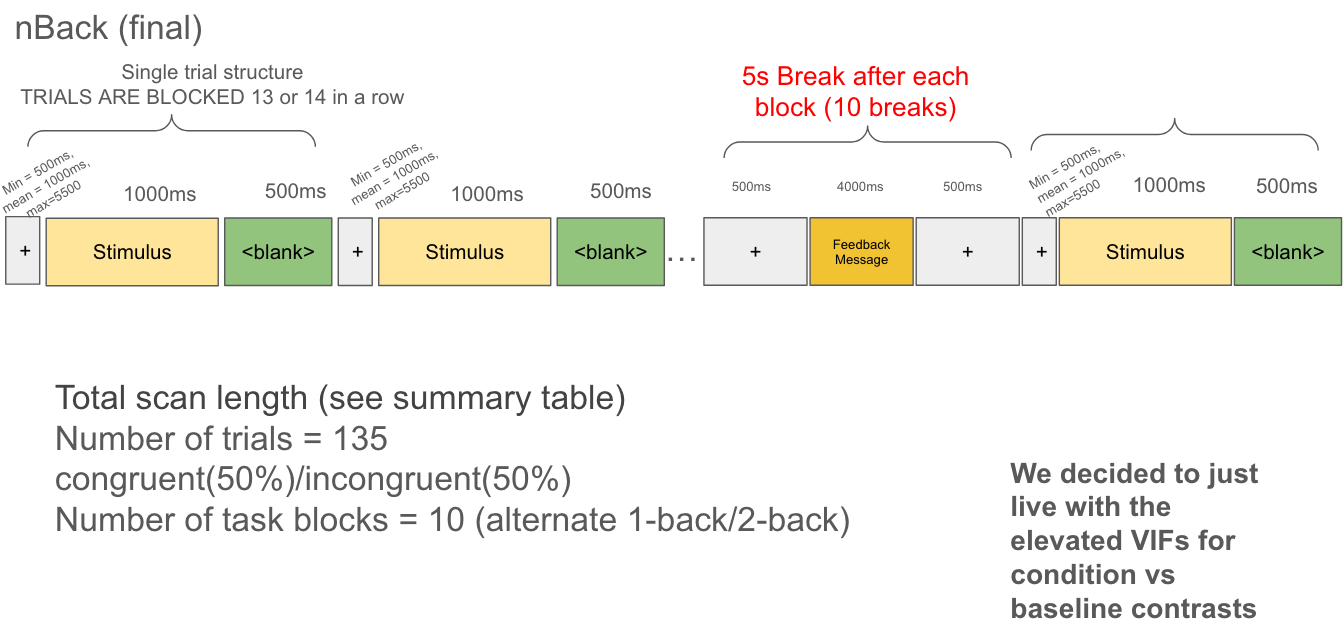

In [2]:
def make_nback_timings(nblocks, n_act_trials_per_block, stim_dur, blank_dur,  
                             break_fix_pre_message_dur, break_message_dur,  
                             break_fix_post_message_dur, isi_exp_lam, isi_truncation, 
                             isi_shift):
    '''
    Set up the nback task.  Blocks will alternate between 1-back and 2-back with breaks
    between each task block
    ISI is sampled from a truncated exponential.  Note the truncation value for the
    truncated exponential does *not* include the shift, so the max isi is
    isi_truncation + isi_shift.
    A  block of trials repeats the following n_trials_per_block times
      but 1 extra trial is added before a 1-back block and 2 extra trials before a 2-back block
      trial is structured as:
      fixation (based on truncated exponential) + 
      stimulus (stim_dur) + blank (blank_dur) + 
      next trial (same structure as above until end of block is reached)
      At end of block the break begins with:
      fixation (length=break_dur) + 
      break message (break_message_dur) + 
      post message fixation (post_message_dur)
    Input:
      n_block: Total number of blocks (will be evenly split between 1-back and 2-back)
      cue_stim_dur/blank_dur: Durations of cue_stim/blank
      blank_dur:  Duration of blank screen after stimulus offset
      break_fix_pre_message_dur: Fixation duration at beginning of break (no jittering)
      break_message_dur:  Duration of message shown during break
      break_fix_post_message_dur:  Fixation duration after message (no jittering)
      isi_exp_lam:  (seconds) The lambda parameter of the exponential used for the isi 
                    (inverse is the non-truncated/non-shifted mean)
      isi_truncation: (seconds) Truncation value of the exponential *NOT* including shift.  
                      Max ISI = isi_truncation + isi_shift
      isi_shift: (seconds) Shift value for isi (minimum isi value)
    Output:
       Events pandas data frame with onsets, trial_type and duration.  
    '''
    if nblocks % 2 != 0:
        raise ValueError('nblocks must be even')
    n_each_back = int(nblocks/2)
    #add in burn in trials
    ntrials = int(n_act_trials_per_block * nblocks + (3*n_each_back))
    block_type = ['one_back','two_back']*n_each_back
    
    fragment_durations = []
    fragment_labels = []
    for block in block_type:
        if block == 'one_back':
            n_extra = 1
        else:
            n_extra = 2
        ntrials_block = n_act_trials_per_block + n_extra
        isi_vals_block, _ = sample_shifted_truncated_exponential(isi_exp_lam, isi_truncation, 
                                          isi_shift, ntrials_block)
        fragment_durations_block = []
        for isi_val in isi_vals_block:
            fragment_durations_block.extend([isi_val, stim_dur, blank_dur])
        fragment_durations_block.extend([break_fix_pre_message_dur, break_message_dur, break_fix_post_message_dur])
        fragment_labels_block = ['fixation', 'starter_trial', 'break']*n_extra + \
                                ['fixation', block, 'break'] * n_act_trials_per_block + \
                                ['fix_break', 'break_message', 'fix_break']
        fragment_durations.extend(fragment_durations_block)
        fragment_labels.extend(fragment_labels_block)

    # If you don't want the beginning of the run to start at 0, change this 
    # (e.g. if you want to add the 10s to reach steady state)
    run_start = 0
    fragment_onsets = np.cumsum([run_start] + fragment_durations)[:-1]       
    events_data = pd.DataFrame({'onset': fragment_onsets,
                                'trial_type': fragment_labels,
                                'duration': fragment_durations})
    events_data = events_data.loc[events_data['trial_type'].str.contains('starter|back|break_message')==True]
    return events_data

In [3]:
events_inputs = {
    'nblocks': 10,
    'n_act_trials_per_block': 12,
    'stim_dur': 1,
    'blank_dur': .5,
    'break_fix_pre_message_dur': .5,
    'break_message_dur': 4,
    'break_fix_post_message_dur': .5,
    'isi_exp_lam': 2,
    'isi_truncation': 4.5,
    'isi_shift': .5
}

tr = 1.49
total_time = 7*60
contrasts = {'1back_v_baseline': 'one_back',
             '2back_v_baseline': 'two_back',
             'all_task': '.5*one_back + .5*two_back',
             '2back-1back': 'two_back-one_back' 
             }

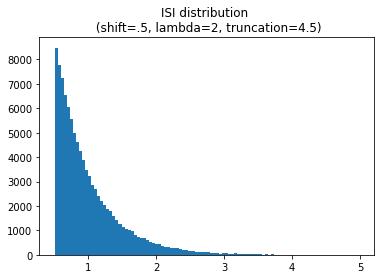

theoretical mean
0.9994445873382422
quartiles
[0.5   0.645 0.847 1.194 4.985]


In [4]:
nsamp = 100000 
samples, theoretical_mean = sample_shifted_truncated_exponential(events_inputs['isi_exp_lam'], events_inputs['isi_truncation'], 
                                                                 events_inputs['isi_shift'], nsamp)
isi_quartiles = np.round(np.quantile(samples, [0, .25, .5, .75, 1]), 3)

plt.hist(samples, 100)
plt.title('ISI distribution \n (shift=.5, lambda=2, truncation=4.5)')
plt.show()
print('theoretical mean')
print(theoretical_mean)
print('quartiles')
print(isi_quartiles)

#### note: pscyhological assessment doesn't make sense here

Obviously we're running this in longer blocks.  I need to run this just so the other code will run okay.

In [5]:
trials_psych_assess_map = {'one_back': '1', 'two_back': '2'}

ntrials = events_inputs['n_act_trials_per_block'] * events_inputs['nblocks']
unpermuted_trials = np.concatenate([np.repeat('1', ntrials/2), 
                                    np.repeat('2', ntrials/2)],
                                    axis=0)
avg_trial_repeats_info = calc_expected_run_num_by_chance(unpermuted_trials, nsims=5000)


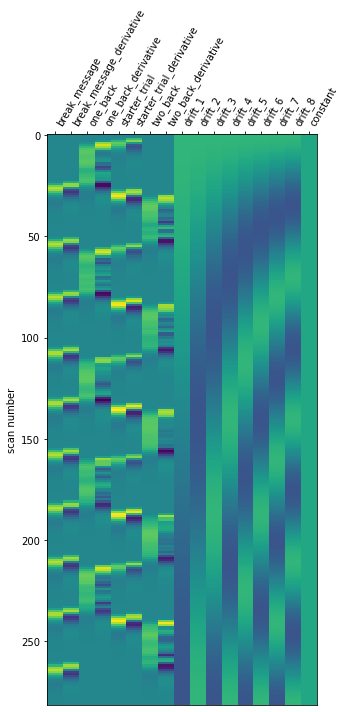

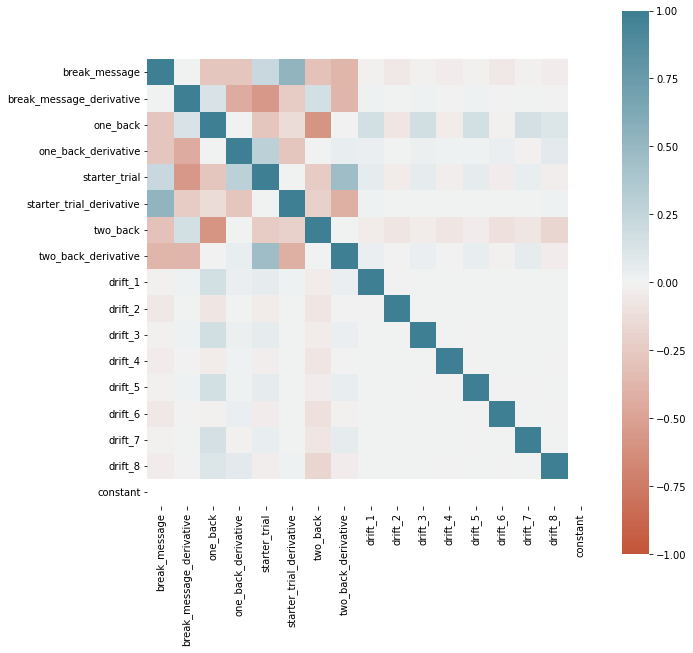

{'1back_v_baseline': 1.3679863889377324, '2back_v_baseline': 1.4736118526334478, 'all_task': 1.4881636690303637, '2back-1back': 7.6140614876616555}
{'1back_v_baseline': 7.834324171199754, '2back_v_baseline': 7.262603852615445, 'all_task': 5.5463565833686, '2back-1back': 1.1229303598813876}


In [6]:
events_ts = make_nback_timings(**events_inputs)
eff, vif, desmat = est_eff_and_vif(events_ts, tr, total_time, contrasts)

plot_design_matrix(desmat)
plt.show()

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(
    desmat.corr(), 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    ax=ax
)
plt.show()

print(eff)
print(vif)

In [7]:
print(events_ts)

          onset     trial_type  duration
1      0.734766  starter_trial       1.0
4      2.957277       one_back       1.0
7      5.222214       one_back       1.0
10     7.320479       one_back       1.0
13    10.052217       one_back       1.0
..          ...            ...       ...
421  374.938780       two_back       1.0
424  377.559899       two_back       1.0
427  381.696384       two_back       1.0
430  383.964808       two_back       1.0
433  385.964808  break_message       4.0

[145 rows x 3 columns]


In [8]:
nsim = 250
output_setting1, events_setting1 = run_eff_sim(nsim, events_inputs, make_nback_timings, 
                               contrasts, avg_trial_repeats_info, tr, total_time,
                               trials_psych_assess_map)

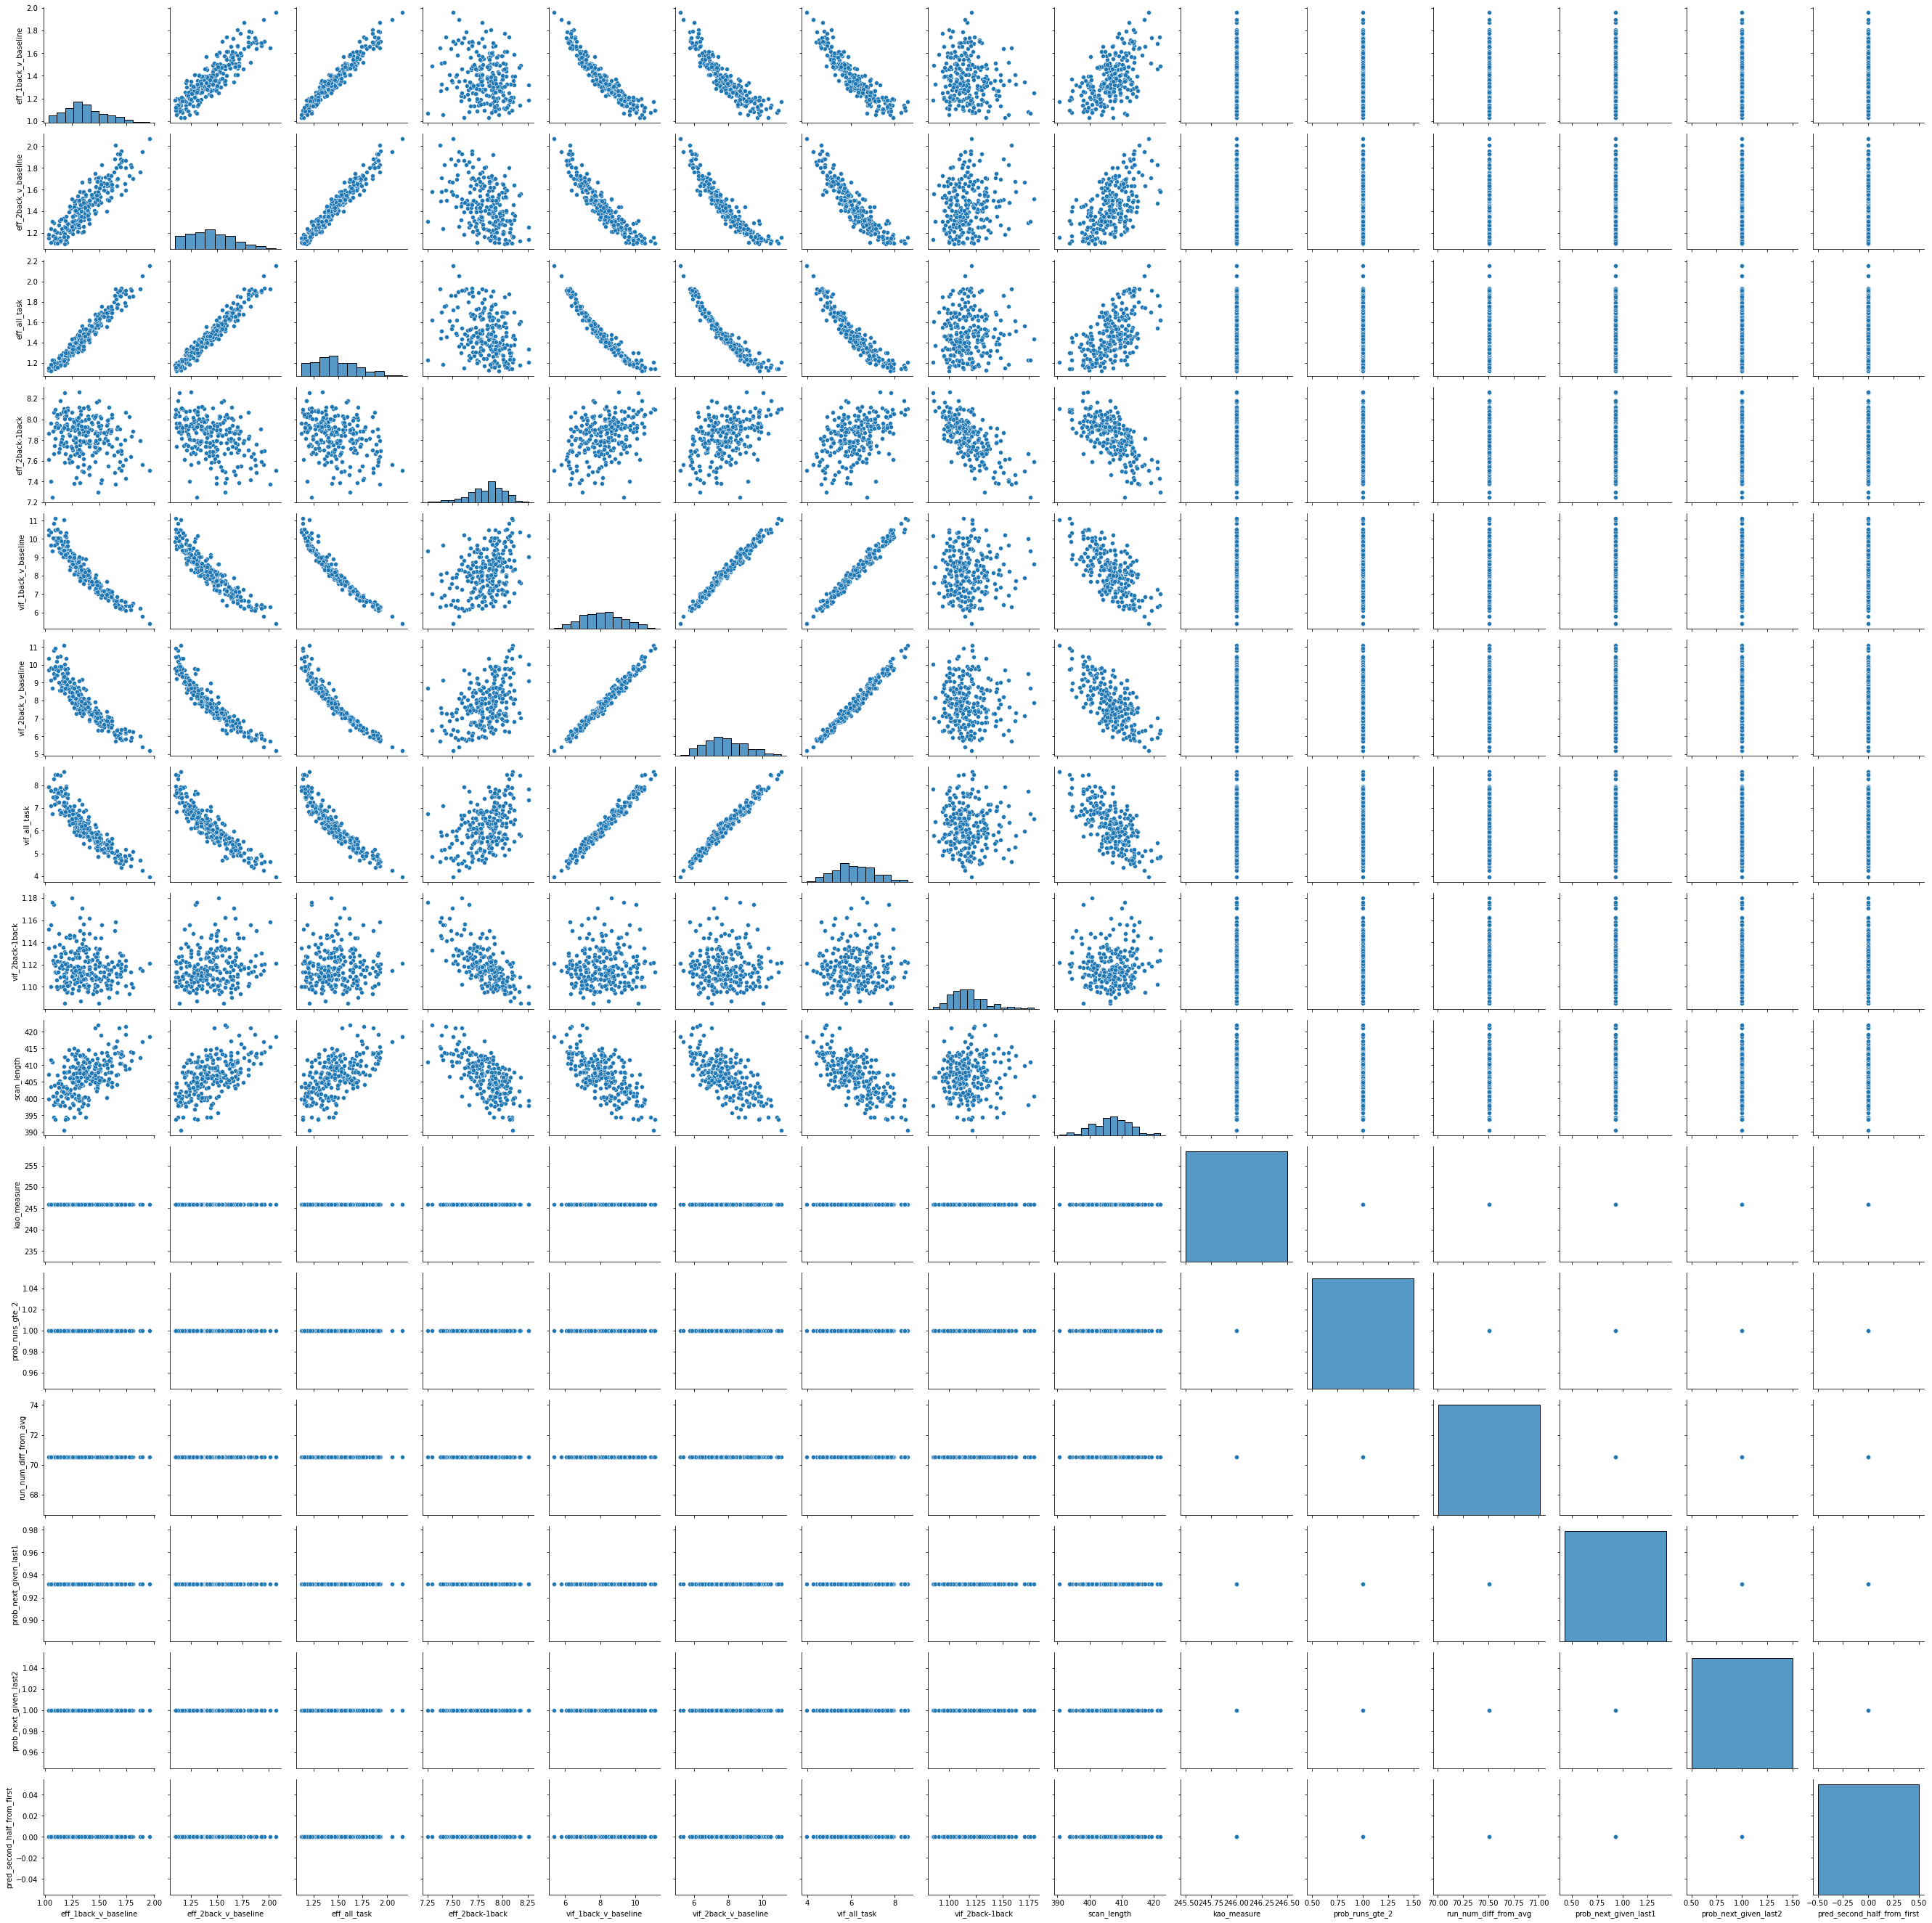

In [9]:
g = sns.PairGrid(output_setting1)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.savefig('/Users/jeanettemumford/Desktop/junk.pdf', format="pdf", bbox_inches="tight")

In [10]:
pd.set_option('display.width', 1000)
eff_vif_summaries = {}
eff_vif_summaries['setting1']= np.round(output_setting1[['eff_1back_v_baseline', 'eff_2back_v_baseline', 'eff_all_task', 
                                                         'eff_2back-1back',
                                                         'vif_1back_v_baseline', 'vif_2back_v_baseline', 'vif_all_task',
                                                         'vif_2back-1back',
                                                         'scan_length']].quantile(q=[.05, .5, .95]), 2)

print(eff_vif_summaries['setting1'])

      eff_1back_v_baseline  eff_2back_v_baseline  eff_all_task  eff_2back-1back  vif_1back_v_baseline  vif_2back_v_baseline  vif_all_task  vif_2back-1back  scan_length
0.05                  1.10                  1.14          1.17             7.50                  6.35                  5.97          4.74             1.10       397.95
0.50                  1.35                  1.43          1.45             7.86                  8.16                  7.78          6.16             1.12       406.78
0.95                  1.70                  1.83          1.89             8.09                 10.13                  9.82          7.78             1.15       414.90


## Increase the fixation around the feedback breaks

efficiencies
{'1back_v_baseline': 2.0724855217141562, '2back_v_baseline': 2.0866780636721236, 'all_task': 2.4555915278633216, '2back-1back': 3.395001945478152}
vifs
{'1back_v_baseline': 5.98203922951157, '2back_v_baseline': 5.685784889047341, 'all_task': 3.650434797167968, '2back-1back': 5.616387697561741}


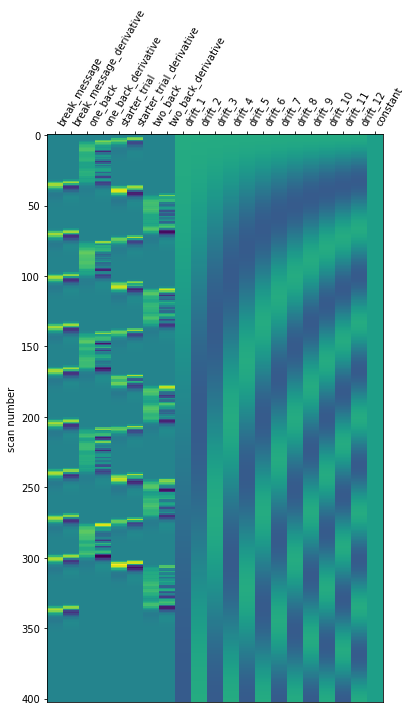

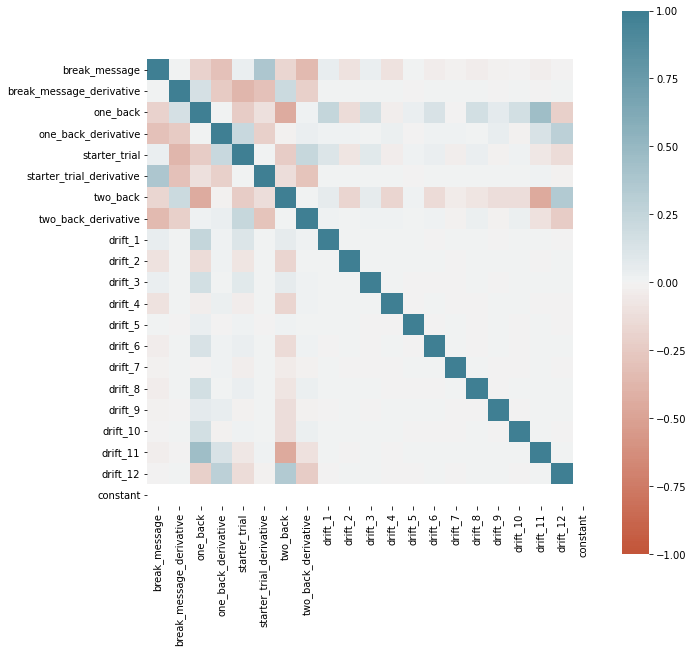

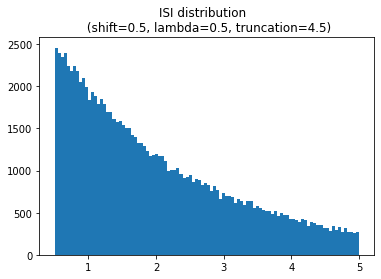

theoretical mean
1.9698232736316372
quartiles
[0.5   1.005 1.676 2.721 5.   ]


In [11]:
events_inputs_longer_message_fix = {
    'nblocks': 10,
    'n_act_trials_per_block': 12,
    'stim_dur': 1,
    'blank_dur': .5,
    'break_fix_pre_message_dur': .5,
    'break_message_dur': 4,
    'break_fix_post_message_dur': .5,
    'isi_exp_lam': .5,
    'isi_truncation': 4.5,
    'isi_shift': .5
}

total_time = 10*60


events_longer_message_fix = make_nback_timings(**events_inputs_longer_message_fix)
eff, vif, desmat_longer_message_fix = est_eff_and_vif(events_longer_message_fix, tr, total_time, contrasts)

print('efficiencies')
print(eff)
print('vifs')
print(vif)

plot_design_matrix(desmat_longer_message_fix)
plt.show()

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(
    desmat_longer_message_fix.corr(), 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    ax=ax
)
plt.show()


nsamp = 100000 
samples, theoretical_mean = sample_shifted_truncated_exponential(events_inputs_longer_message_fix['isi_exp_lam'], events_inputs_longer_message_fix['isi_truncation'], 
                                                                 events_inputs_longer_message_fix['isi_shift'], nsamp)
isi_quartiles = np.round(np.quantile(samples, [0, .25, .5, .75, 1]), 3)

plt.hist(samples, 100)
plt.title(f"ISI distribution  \n (shift={events_inputs_longer_message_fix['isi_shift']}, lambda={events_inputs_longer_message_fix['isi_exp_lam']}, truncation={events_inputs_longer_message_fix['isi_truncation']})")
plt.show()
print('theoretical mean')
print(theoretical_mean)
print('quartiles')
print(isi_quartiles)
